### Alter the surface data file to delimit three tropical PFTs

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import rioxarray as rx
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

from cartopy.io.shapereader import Reader
import shapefile
from shapely.geometry import shape, Point, LinearRing

import regionmask

from shapely.geometry import MultiPolygon, Polygon

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Surface data file
Read in the defaut global file

In [2]:
surf = '/global/homes/j/jneedham/tropical-fixed-biog/domainsurf/surfdata_4x5_simyr2000_c130927.nc'
surf = xr.open_dataset(surf, decode_times=False)

In [3]:
fates = '/pscratch/sd/j/jneedham/elm_runs/fbnc_cal/apr24/fbnc_f45_v3_rdark_vert_1.E5e483733fa-F77ac7623.2024-04-24/run/fbnc_f45_v3_rdark_vert_1.E5e483733fa-F77ac7623.2024-04-24.2190s.nc'
fates = xr.open_dataset(fates, decode_times=False)
fates_lon = fates.coords['lon']
fates_lat = fates.coords['lat']

In [4]:
# Rename lat and lon and assign coordinates
surf = surf.rename({'lsmlat': 'lat', 'lsmlon':'lon'})
surf = surf.assign_coords({'lon':fates_lon})
surf = surf.assign_coords({'lat':fates_lat})

### Plot them 

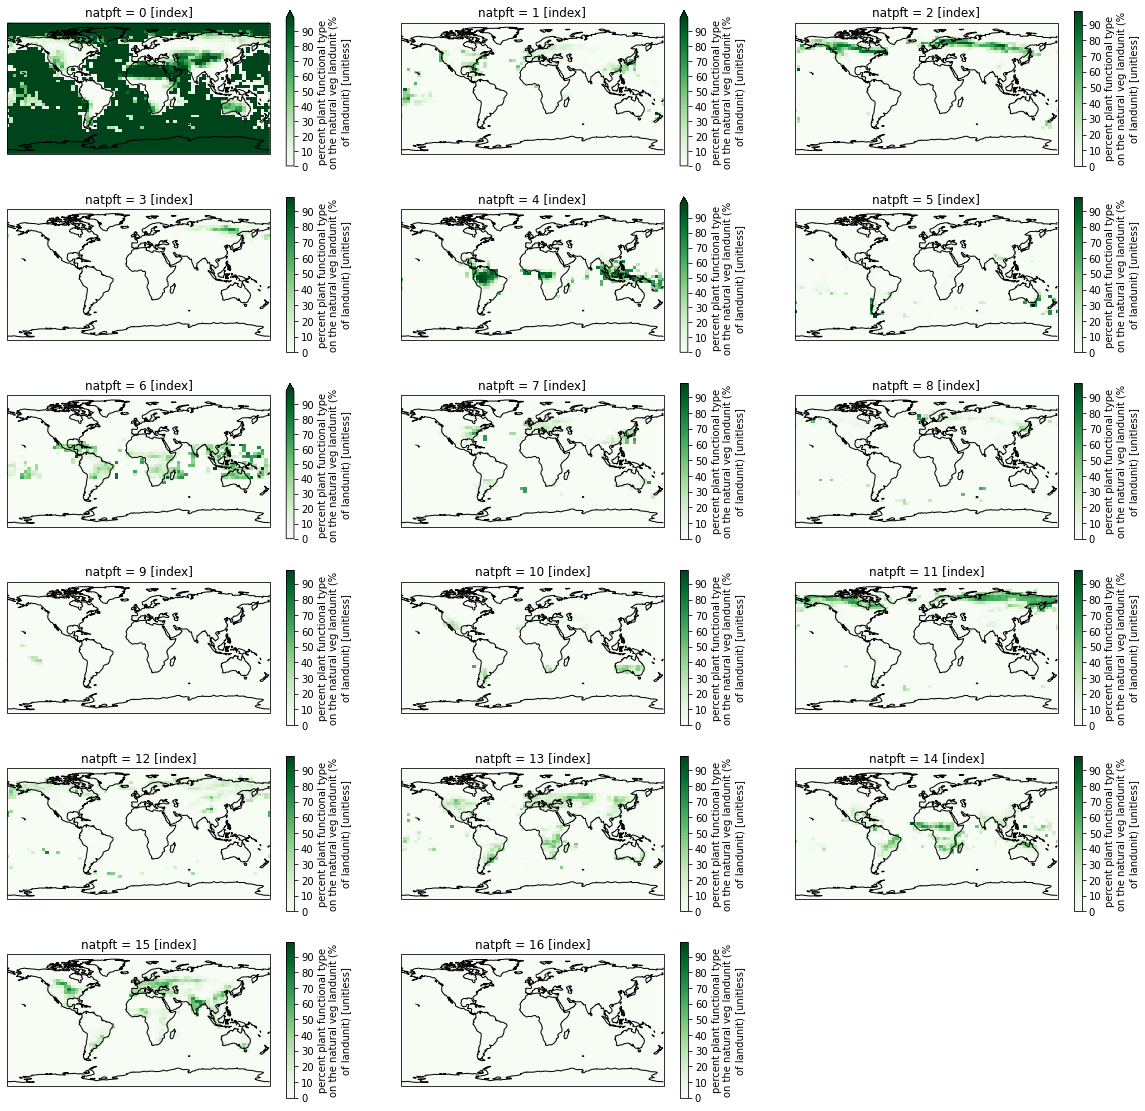

In [5]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,20))
axs = axs.flatten()

clevs=np.arange(0,100,1)

for i in range(0,17):
    cs = surf.PCT_NAT_PFT.isel(natpft=i).plot(levels=clevs,cmap='Greens', ax=axs[i])
    axs[i].coastlines()

fig.delaxes(axs[17])

### Crop to just the tropics

In [6]:
cropped_surf = surf.isel(lat=slice(15,31))

if (cropped_surf['PCT_NAT_PFT'] < 0).any():
    print('YES')

#### 1. Copy HLM pft 4 to pfts  1,2,3 and HLM pft 6 to pfts 4,5,6 and  pft 14 to pft 7

In [7]:
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=1)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=4)
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=2)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=4)
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=3)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=4)

cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=4)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=6)
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=5)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=6)
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=6)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=6)

cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=7)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=14)

#### 4. Zero out all the other pfts

In [8]:
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=8)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=9)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=10)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=11)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=12)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=13)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=14)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=15)] = 0
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=16)] = 0

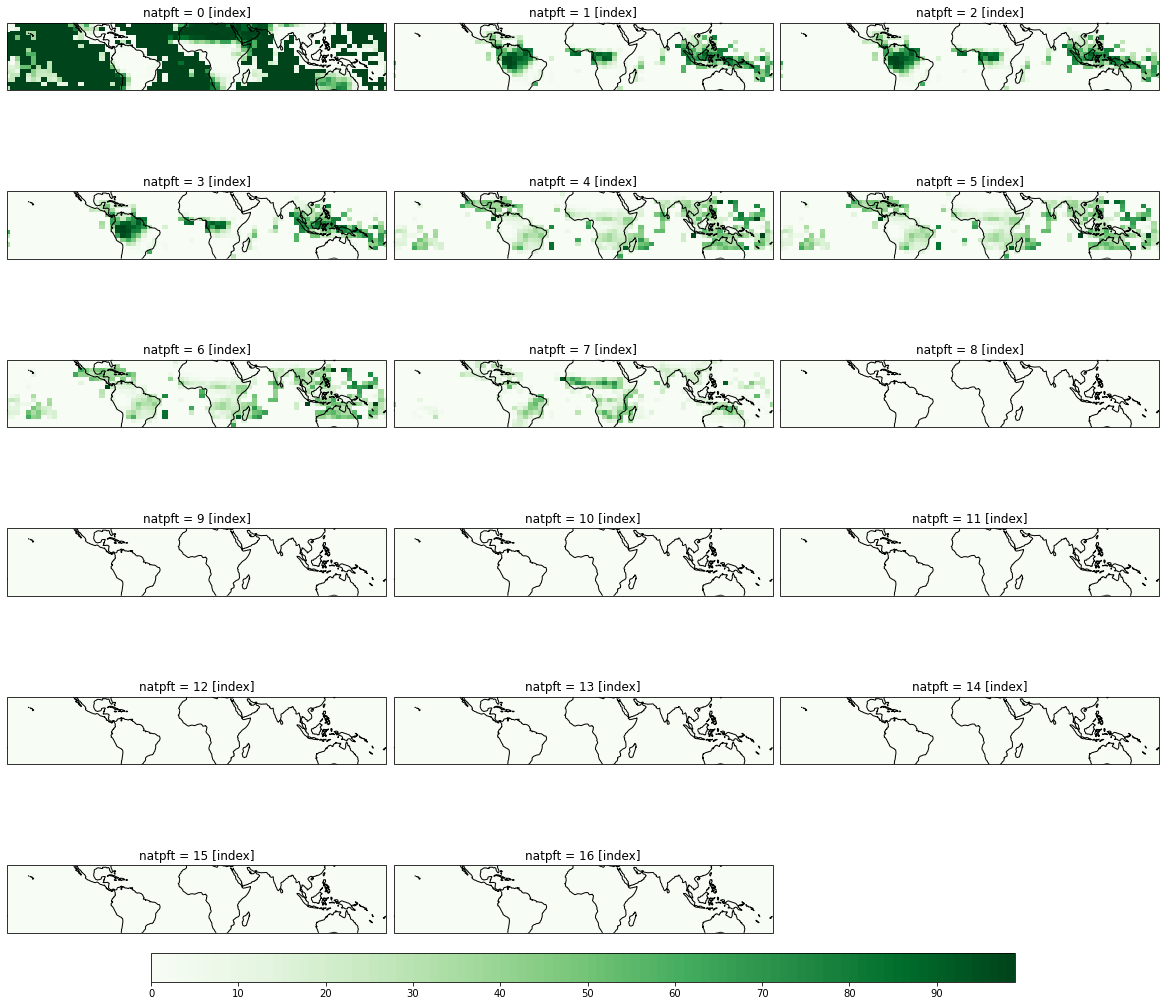

In [9]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,20))
axs = axs.flatten()

clevs=np.arange(0,100,1)

for i in range(0,17):
    cs = cropped_surf.PCT_NAT_PFT.isel(natpft=i).plot(levels=clevs,cmap='Greens', ax=axs[i],
                                                     add_colorbar=False)
    axs[i].coastlines()

fig.delaxes(axs[17])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')    

#### 5. Zero out PFTs  1 and  4 outside americas

In [10]:
#min_lon_index = 37
#max_lon_index = 69

# use actual lon values (not indices)
min_lon_index = 185
max_lon_index = 345

lon_mask = (cropped_surf.lon >= min_lon_index) & (cropped_surf.lon <= max_lon_index) 
mask = lon_mask

cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=1)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=1).where(mask, 0)
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=4)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=4).where(mask, 0)

#### 6. zero out PFTs 2 and 5 outside africa

In [11]:
min_lon_index = 0
max_lon_index = 65
min_lon_index2 = 345
max_lon_index2 = 360

lon_mask = (cropped_surf.lon >= min_lon_index) & (cropped_surf.lon <= max_lon_index)
lon_mask2 = (cropped_surf.lon >= min_lon_index2) & (cropped_surf.lon <= max_lon_index2)

mask = lon_mask | lon_mask2

cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=2)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=2).where(mask, 0)
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=5)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=5).where(mask, 0)

#### 7. zero out PFts 3 and 6 outside asia 

In [12]:
min_lon_index = 65
max_lon_index = 185

lon_mask = (cropped_surf.lon >= min_lon_index) & (cropped_surf.lon <= max_lon_index) 
mask = lon_mask

cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=3)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=3).where(mask, 0)
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=6)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=6).where(mask, 0)

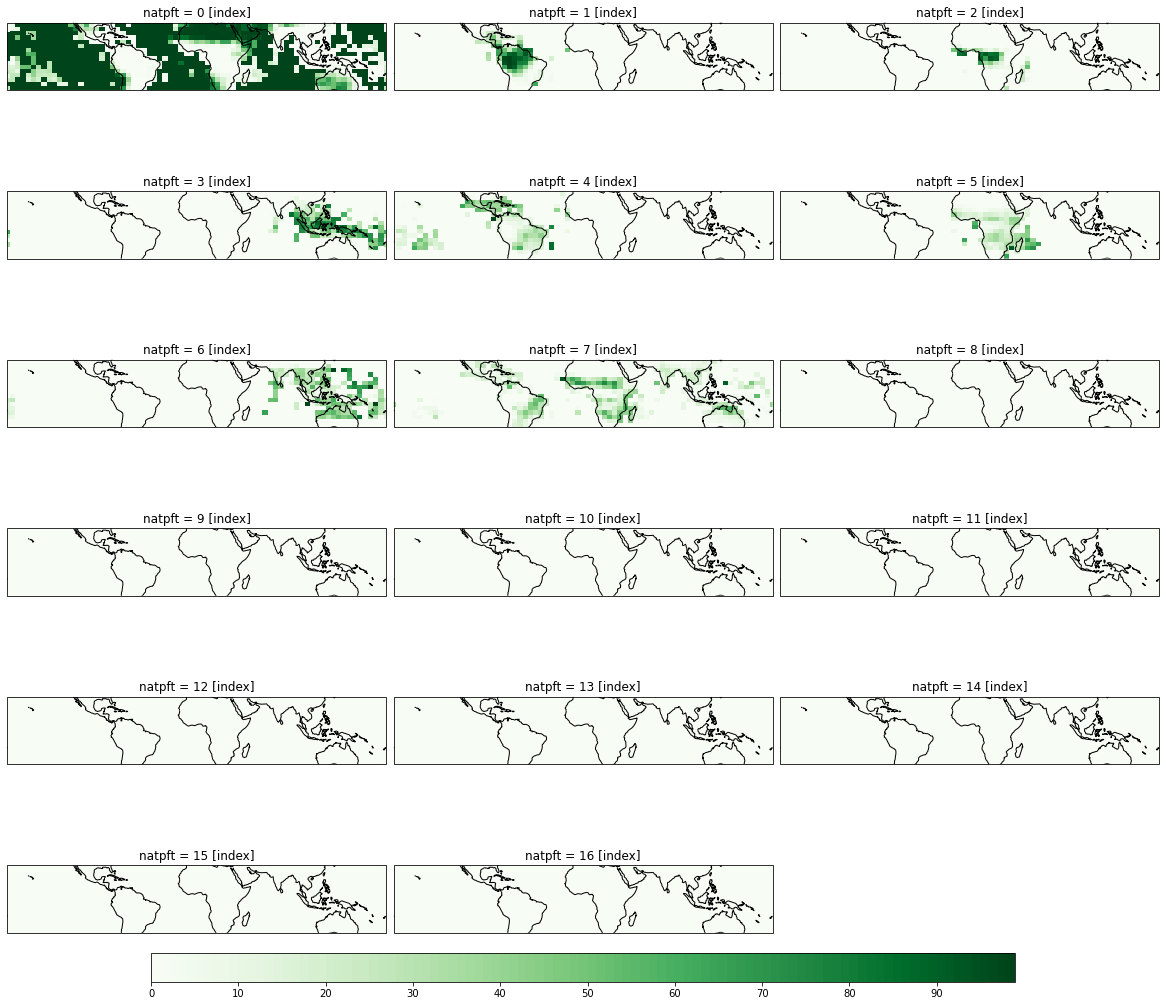

In [13]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,20))
axs = axs.flatten()

clevs=np.arange(0,100,1)

for i in range(0,17):
    cs = cropped_surf.PCT_NAT_PFT.isel(natpft=i).plot(levels=clevs,cmap='Greens', ax=axs[i],
                                                     add_colorbar=False)
    axs[i].coastlines()

fig.delaxes(axs[17])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')    

### Make sure PFTs sum to 100 in each grid cell  

In [14]:
sums = cropped_surf['PCT_NAT_PFT'].sum(dim='natpft')

# also quick check for negative  %s
if (cropped_surf['PCT_NAT_PFT'] < 0).any():
    print('YES')

#### Do any grid  cells exceed 100? 

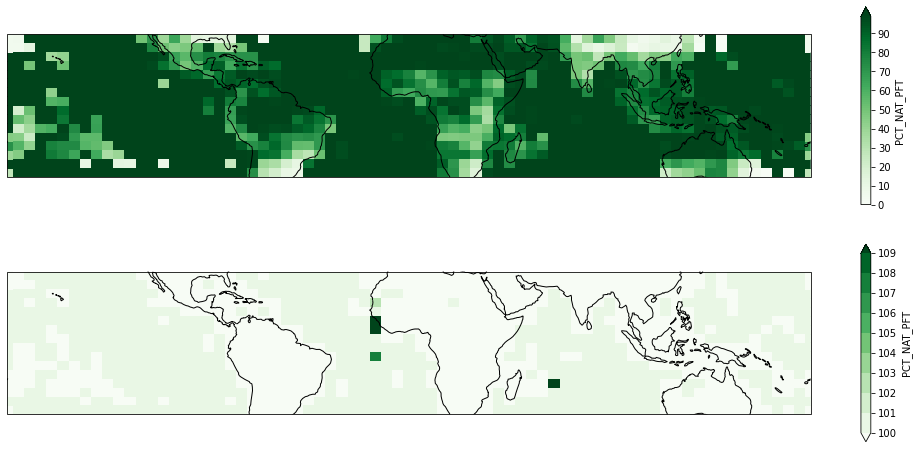

In [15]:
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,8))
axs = axs.flatten()
clevs=np.arange(0,100,1)
cs = sums.plot(levels=clevs,cmap='Greens', ax=axs[0])
axs[0].coastlines()

clevs=np.arange(100,110,1)
cs = sums.plot(levels=clevs,cmap='Greens', ax=axs[1])
axs[1].coastlines()


#### Remove excess PFTs

1. Where are the grid cells with >100%  PFTs?

2. In those grid cells remove excess from C4 grass (but don't let it go negative)

3. If still excess, remove excess from bare ground (but  don't let it go negative)

4. If  still excess remove excess from drought deciduous (but don't let it go negative)


In [16]:
#  1.
# Where does % of PFTs exceed 100?
diffs = sums - 100
# mask  out the negative numbers with 0 - now the only numbers are  positive - excess PFTs
diffs = diffs.where(diffs >= 0,0)

# 2.
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=7)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=7) - diffs
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=7)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=7).where(cropped_surf['PCT_NAT_PFT'].isel(natpft=7) >=0, 0)

sums = cropped_surf['PCT_NAT_PFT'].sum(dim='natpft')
diffs = sums - 100
# mask  out the negative numbers with 0 - now the only numbers are  positive - excess PFTs
diffs = diffs.where(diffs >= 0,0)


In [17]:
# 3.
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=0)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=0) - diffs
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=0)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=0).where(cropped_surf['PCT_NAT_PFT'].isel(natpft=0) >=0, 0)

sums = cropped_surf['PCT_NAT_PFT'].sum(dim='natpft')
diffs = sums - 100
# mask  out the negative numbers with 0 - now the only numbers are  positive - excess PFTs
diffs = diffs.where(diffs >= 0,0)


In [18]:
# 4.
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=5)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=5) - diffs
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=5)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=5).where(cropped_surf['PCT_NAT_PFT'].isel(natpft=5) >=0, 0)

sums = cropped_surf['PCT_NAT_PFT'].sum(dim='natpft')
diffs = sums - 100
# mask  out the negative numbers with 0 - now the only numbers are  positive - excess PFTs
diffs = diffs.where(diffs >= 0,0)


In [19]:
#  5.  
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=2)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=2) - diffs
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=2)] = cropped_surf['PCT_NAT_PFT'].isel(natpft=2).where(cropped_surf['PCT_NAT_PFT'].isel(natpft=5) >=0, 0)

sums = cropped_surf['PCT_NAT_PFT'].sum(dim='natpft')
diffs = sums - 100
# mask  out the negative numbers with 0 - now the only numbers are  positive - excess PFTs
diffs = diffs.where(diffs >= 0,0)


In [21]:
if (cropped_surf['PCT_NAT_PFT'] < 0).any():
    print('YES')

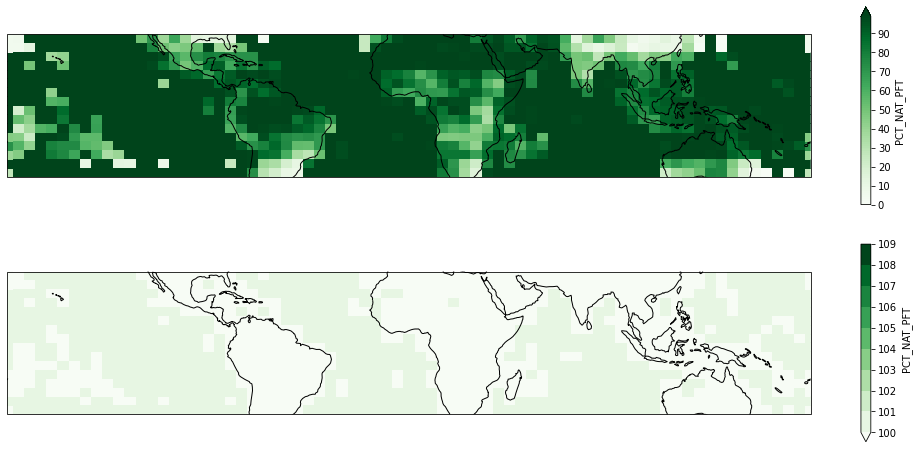

In [22]:
sums = cropped_surf['PCT_NAT_PFT'].sum(dim='natpft')
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,8))
axs = axs.flatten()
clevs=np.arange(0,100,1)
cs = sums.plot(levels=clevs,cmap='Greens', ax=axs[0])
axs[0].coastlines()

clevs=np.arange(100,110,1)
cs = sums.plot(levels=clevs,cmap='Greens', ax=axs[1])
axs[1].coastlines()


### Fill in the gaps with C3  grass as a placeholder for crops

In [23]:
crop_pct = 100 - sums

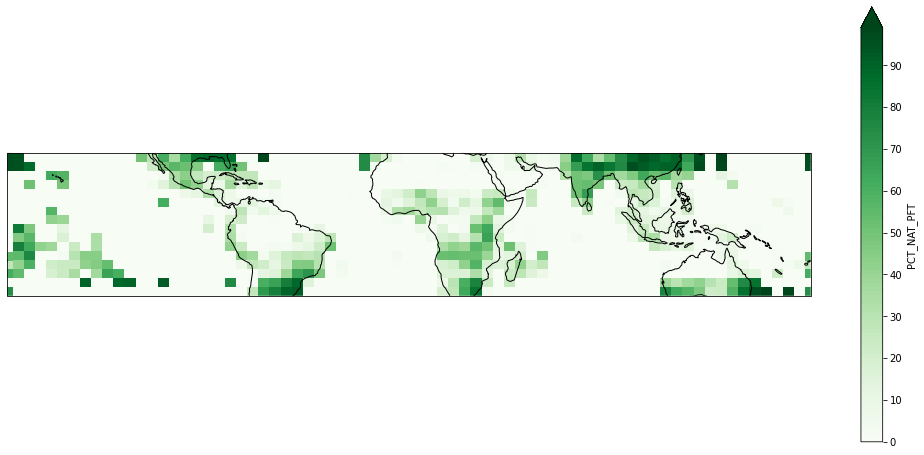

In [24]:
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,8))

clevs=np.arange(0,100,1)

cs = crop_pct.plot(levels=clevs,cmap='Greens', ax=axs)
axs.coastlines()

In [25]:
cropped_surf['PCT_NAT_PFT'].loc[dict(natpft=8)] = crop_pct

In [26]:
sums = cropped_surf['PCT_NAT_PFT'].sum(dim='natpft')

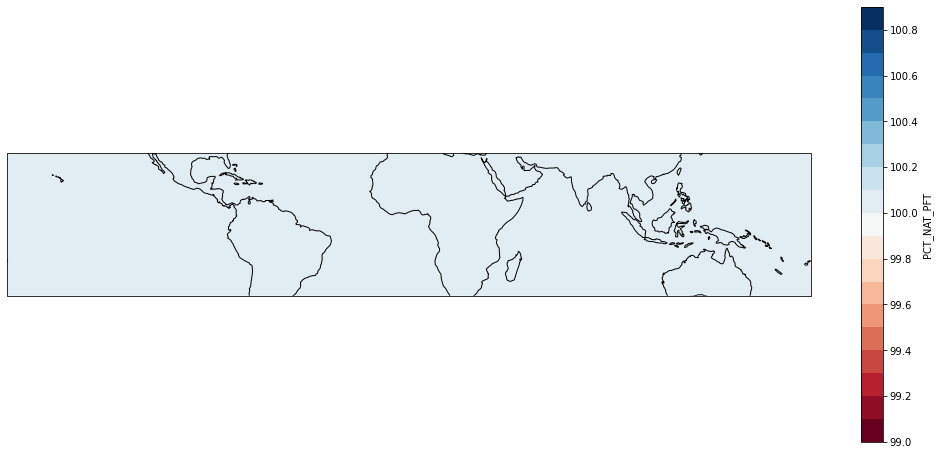

In [27]:
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,8))

clevs=np.arange(99,101,0.1)

cs = sums.plot(levels=clevs,cmap='RdBu', ax=axs)
axs.coastlines()


### checks for negative values  or any grid  cell exceeding 100

In [28]:
if (cropped_surf['PCT_NAT_PFT'] < 0).any():
    print('YES')

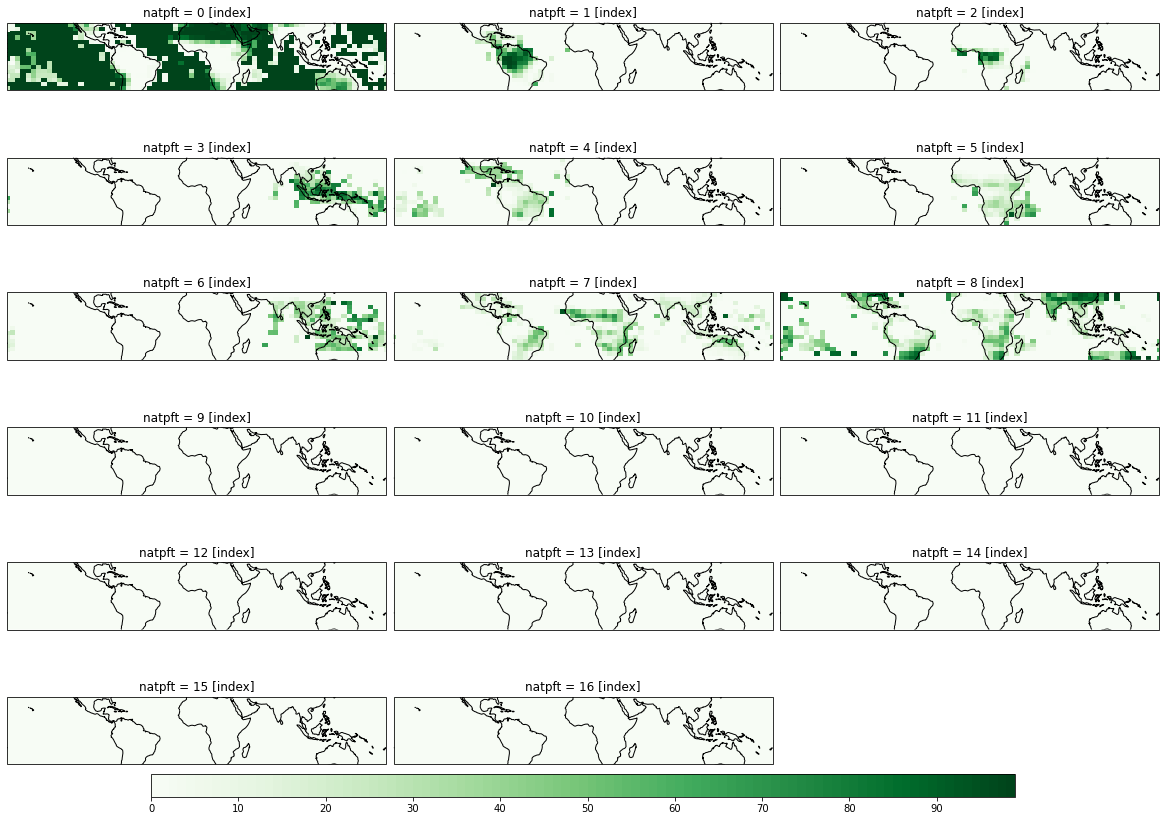

In [29]:
fig, axs = plt.subplots(nrows=6,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,16))
axs = axs.flatten()

clevs=np.arange(0,100,1)

for i in range(0,17):
    cs = cropped_surf.PCT_NAT_PFT.isel(natpft=i).plot(levels=clevs,cmap='Greens', ax=axs[i],
                                                     add_colorbar=False)
    axs[i].coastlines()

fig.delaxes(axs[17])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')    

### revert the lat lon  dimensions 

In [30]:
cropped_surf = cropped_surf.rename({'lat': 'lsmlat', 'lon':'lsmlon'})

In [31]:
# save the new file 
cropped_surf.to_netcdf('/global/homes/j/jneedham/tropical-fixed-biog/domainsurf/surf_nocomp.nc')
